In [1]:
import cv2
import ast
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def getBoxesIntersect(boxA, boxB):
        if boxA[0] > boxB[2]:
            return False  # boxA is right of boxB
        if boxB[0] > boxA[2]:
            return False  # boxA is left of boxB
        if boxA[3] < boxB[1]:
            return False  # boxA is above boxB
        if boxA[1] > boxB[3]:
            return False  # boxA is below boxB
        return True

def getIntersectionArea(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # intersection area
    return (xB - xA + 1) * (yB - yA + 1)

def getUnionAreas(boxA, boxB, interArea=None):
    area_A = getArea(boxA)
    area_B = getArea(boxB)
    if interArea is None:
        interArea = getIntersectionArea(boxA, boxB)
    return float(area_A + area_B - interArea)

def getArea(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)

def get_iou(boxA, boxB):
    if getBoxesIntersect(boxA, boxB) is False:
        return 0
    interArea = getIntersectionArea(boxA, boxB)
    union = getUnionAreas(boxA, boxB, interArea=interArea)
    iou = interArea / union
    assert iou >= 0
    return iou

In [3]:
IOUThreshold = 0.5

def get_iou_info(pred_bboxes, gt_bboxes):
    # Get only detection of class c
    dects = pred_bboxes
    FP_boxes = []
    
    iou_sum = 0
    TP = 0
    gt_usablecheck = [True] * len(gt_bboxes)
    for d in range(len(dects)):
        gt = gt_bboxes
        iouMax = 0
        for j in range(len(gt)):
            iou = get_iou(dects[d], gt[j])
            if iou > iouMax:
                iouMax = iou
                jmax = j

        if iouMax >= IOUThreshold:
            if gt_usablecheck[jmax]:
                gt_usablecheck[jmax] = False
                iou_sum += iouMax
                TP += 1
            else:
                FP_boxes.append(dects[d])
        else:
            FP_boxes.append(dects[d])
        
    num = len(pred_bboxes) + len(gt_bboxes) - TP
    return (iou_sum, num, TP, FP_boxes)

In [4]:
def get_det_info(model_name, mixed_image_name):
    det_log = './outputs/det_logs/'+mixed_image_name+'_'+model_name+'.log'
    with open(det_log, 'r') as f:
        boxes = f.readline()
        boxes = ast.literal_eval(boxes)[0]
        confs = f.readline()
        confs = ast.literal_eval(confs)[0]
        classes = f.readline()
        classes = ast.literal_eval(classes)[0]
    return (boxes, confs, classes)

In [5]:
def get_gt_info(mixed_image_name):
    size_key = 'size50to150'
    gt_log = './data/dataset/coco_mixed_val.txt'
    with open(gt_log, 'r') as f:
        gts = f.readlines()
    for i in range(len(gts)):
        line = gts[i]
        if size_key in line and mixed_image_name in line:
            gt_bboxes = line.rsplit()[1:]
            gt_bboxes = [[int(e) for e in gt_bbox.split(',')] for gt_bbox in gt_bboxes]
    return gt_bboxes

In [10]:
mixed_image_names = ['mix000000', 'mix000001', 'mix000002', 'mix000003', 'mix000004']
model_names = ['ckpt_0000_1', 'ckpt_0001_1', 'ckpt_00005', 'ckpt_0101_1', 'ckpt_0101',  
              'ckpt_0303_1', 'ckpt_0303', 'ckpt_0307', 'ckpt_0703', 'ckpt_1010', 'default']

det_dict = {}
gt_dict = {}
pred_dict = {}

for mixed_image_name in mixed_image_names:
    for model_name in model_names:
        det_key = model_name + '_' + mixed_image_name
        det_dict[det_key] = get_det_info(model_name, mixed_image_name)
    gt_dict[mixed_image_name] = get_gt_info(mixed_image_name)

for mixed_image_name in mixed_image_names:
    for model_name in model_names:
        pred_bboxes = []
        key = model_name + '_' + mixed_image_name
        boxes, confs, classes = det_dict[key]
        for box, conf, c in zip(boxes, confs, classes):
            if int(c) == 0:
                b = [int(800*float(p)) for p in box]
                b = [b[1], b[0], b[3], b[2], float(conf)]
                pred_bboxes.append(b)
        pred_dict[key] = pred_bboxes

In [16]:
def get_info(model_name, mixed_image_name, conf_threshold=0.3):
    pred_bboxes = pred_dict[model_name+'_'+mixed_image_name]
    pred_bboxes = [pb for pb in pred_bboxes if pb[4] >= conf_threshold]
    gt_bboxes = gt_dict[mixed_image_name]
    iou_sum, num, TP, FP_boxes = get_iou_info(pred_bboxes, gt_bboxes)
    return (iou_sum, num, TP, len(gt_bboxes), pred_bboxes, FP_boxes)

In [12]:
def get_miou(model_name, mixed_image_name, conf_threshold=0):
    iou_sum, num, TP, gt_len, pred_bboxes, fp_boxes = get_info(model_name, mixed_image_name, conf_threshold)
    return iou_sum/num

In [13]:
def visualize_conf_distribution(tp, fp):
    tp_confs = np.array(tp)[:,4]
    fp_confs = np.array(fp)[:,4]
    x1 = np.arange(0, len(tp_confs))
    x2 = np.arange(0, len(fp_confs))
    plt.hist(tp_confs, bins=30, alpha=0.85, label='tp_conf')
    plt.hist(fp_confs, bins=30, alpha=0.85, label='fp_conf')
    plt.legend()
    plt.show()

In [17]:
model_names = ['ckpt_0101']
mixed_image_names = ['mix000000']
for model_name in model_names:
    model_miou_sum = 0
    for mixed_image_name in mixed_image_names:
        _, _, _, _, _, fps = get_info(model_name, mixed_image_name, 0)
        fp_confs = np.array(fps)[:,4]
        max_miou = 0
        max_conf_thres = 0
        for fp_conf in fp_confs:
            miou = get_miou(model_name, mixed_image_name, fp_conf)
            if max_miou < miou:
                max_miou = miou
                max_conf_thres = fp_conf
        print(max_miou, max_conf_thres)

0.5422475560961664 0.4437110424041748


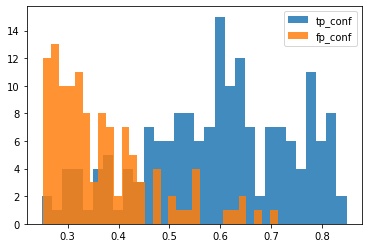

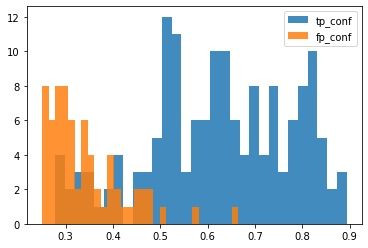

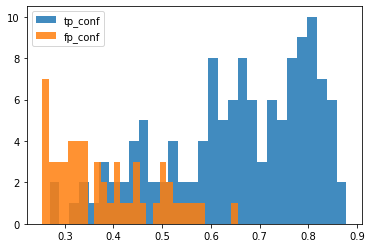

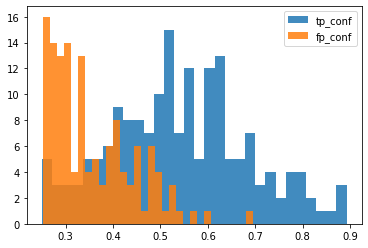

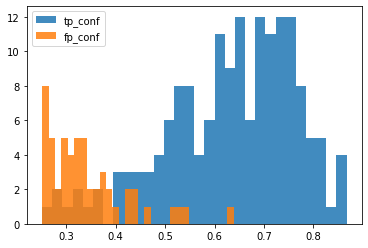

['ckpt_0101', 0.4850915413183408]


In [85]:
mixed_image_names = ['mix000000', 'mix000001', 'mix000002', 'mix000003', 'mix000004']
# model_names = ['ckpt_0000_1', 'ckpt_0001_1', 'ckpt_00005', 'ckpt_0101_1', 'ckpt_0101',  
#               'ckpt_0303_1', 'ckpt_0303', 'ckpt_0307', 'ckpt_0703', 'ckpt_1010', 'default']
model_names = ['ckpt_0101']
model_miou_list = []
for model_name in model_names:
    model_miou_sum = 0
    for mixed_image_name in mixed_image_names:
        iou_sum, num, TP, gt_len, pred_bboxes, fp_boxes = get_info(model_name, mixed_image_name)
        miou = iou_sum/num
        model_miou_sum += miou
        tp = [p for p in pred_bboxes if p not in fp_boxes]
        visualize_conf_distribution(tp, fp_boxes)
    model_miou_list.append([model_name, model_miou_sum/len(mixed_image_names)])
model_miou_list = sorted(model_miou_list, key=lambda x: x[1], reverse=True)
for mm in model_miou_list:
    print(mm)

# Calculate mIoU

In [95]:
mixed_image_names = ['mix000000', 'mix000001', 'mix000002', 'mix000003', 'mix000004']
model_names = ['ckpt_0000_1', 'ckpt_0001_1', 'ckpt_00005', 'ckpt_0101_1', 'ckpt_0101',  
              'ckpt_0303_1', 'ckpt_0303', 'ckpt_0307', 'ckpt_0703', 'ckpt_1010', 'default']
model_miou_list = []
for model_name in model_names:
    model_miou_sum = 0
    for mixed_image_name in mixed_image_names:
        iou_sum, num, TP, gt_len, pred_bboxes, fp_boxes = get_info(model_name, mixed_image_name)
        miou = iou_sum/num
        model_miou_sum += miou
    model_miou_list.append([model_name, model_miou_sum/len(mixed_image_names)])
model_miou_list = sorted(model_miou_list, key=lambda x: x[1], reverse=True)
for mm in model_miou_list:
    print(mm)

['ckpt_0101', 0.5282905295030792]
['ckpt_0307', 0.5225665744929493]
['ckpt_0303', 0.5199496587316608]
['ckpt_1010', 0.5153351165102045]
['ckpt_0303_1', 0.5025551867779827]
['ckpt_0703', 0.4975402472229245]
['ckpt_0101_1', 0.49126874249254876]
['default', 0.3060790214307748]
['ckpt_0001_1', 0.23120855617646816]
['ckpt_00005', 0.18415133449144258]
['ckpt_0000_1', 0.14138609085914564]


# Check Prediction bboxes

In [36]:
def draw_bbox(image, bboxes, linecolor=(255, 0, 0)):
    for b in bboxes:
        c1, c2 = (b[0], b[1]), (b[2], b[3])
        cv2.rectangle(image, c1, c2, linecolor, 2)
    return image

In [37]:
def visualize(model_name, mixed_image_name):
    iou_sum, num, TP, gt_len, pred_bboxes, fp_boxes = get_info(model_name, mixed_image_name)

    original_image = cv2.imread('./data/mixed_images/'+mixed_image_name+'.png')
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    image = draw_bbox(original_image, pred_bboxes)
    image = draw_bbox(image, fp_boxes, (0, 255, 0))

    plt.figure(figsize=(12,12))
    plt.title(model_name+' '+mixed_image_name)
    plt.imshow(image)
    plt.show()
    
    print(model_name, mixed_image_name)
    print('pd_boxes',len(pred_bboxes))
    print('gt_boxes',gt_len)
    print('TP',TP)
    print('FP',len(fp_boxes))
    print('num',num)
    print('fp_boxes', fp_boxes)
    print('miou',iou_sum/num) 

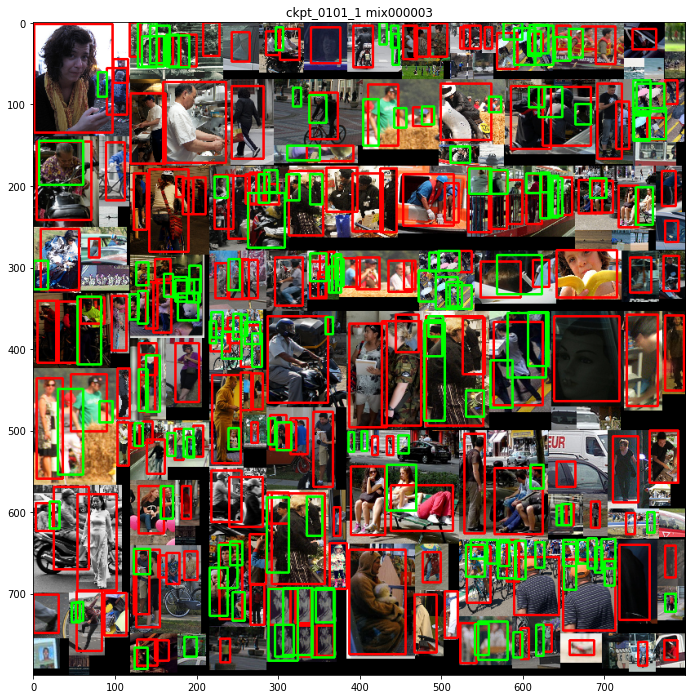

ckpt_0101_1 mix000003
pd_boxes 326
gt_boxes 219
TP 183
FP 143
num 362
fp_boxes [[545, 734, 581, 781, 0.7918720841407776], [616, 738, 625, 776, 0.7428502440452576], [641, 592, 648, 616, 0.6885864734649658], [318, 80, 328, 103, 0.6855658888816833], [433, 542, 469, 598, 0.6636279821395874], [184, 498, 196, 532, 0.6556124687194824], [656, 8, 673, 43, 0.6245795488357544], [156, 568, 171, 608, 0.6156080365180969], [774, 700, 787, 722, 0.6076931357383728], [621, 186, 633, 240, 0.6048021912574768], [493, 312, 520, 351, 0.6024805307388306], [298, 490, 316, 524, 0.5939345359802246], [609, 542, 625, 571, 0.5845771431922913], [81, 464, 97, 490, 0.5772868394851685], [534, 179, 561, 210, 0.57187819480896], [126, 294, 141, 322, 0.5699549317359924], [589, 7, 615, 52, 0.5669243335723877], [341, 695, 369, 778, 0.5624725222587585], [738, 202, 759, 248, 0.5580190420150757], [442, 105, 457, 129, 0.5569531917572021], [222, 189, 238, 215, 0.5487391948699951], [664, 100, 683, 125, 0.5471839308738708], [472, 3

In [ ]:
selected_models = ['ckpt_0101_1', 'ckpt_1010', 'ckpt_0703', 'default']
mixed_image_name = 'mix000003'
for model_name in selected_models:
    visualize(model_name, mixed_image_name)

In [20]:
def get_gt_bboxes(mixed_image_name):
    size_key = 'size50to150'
    gt_log = './data/dataset/coco_mixed_val.txt'
    with open(gt_log, 'r') as f:
        gts = f.readlines()
    for i in range(len(gts)):
        line = gts[i]
        if size_key in line and mixed_image_name in line:
            gt_bboxes = line.rsplit()[1:]
            gt_bboxes = [[int(e) for e in gt_bbox.split(',')] for gt_bbox in gt_bboxes]
    return gt_bboxes

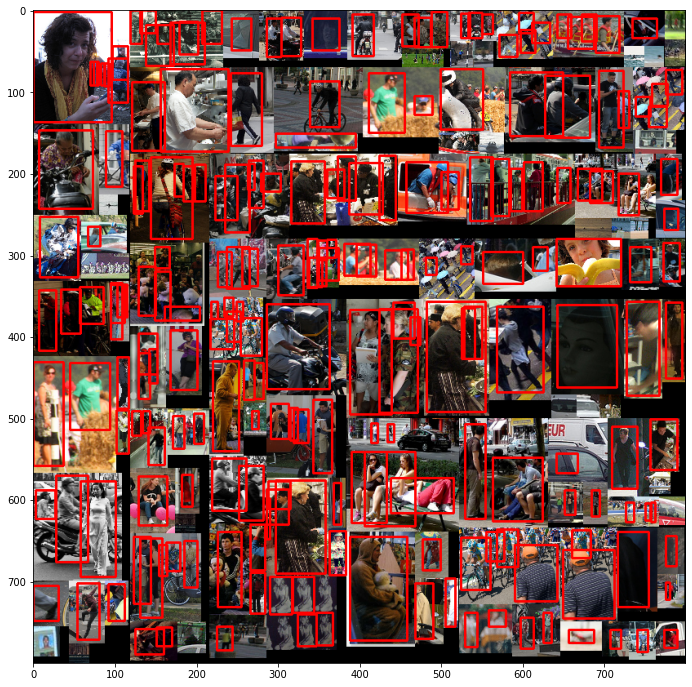

In [30]:
original_image = cv2.imread('./data/mixed_images/'+mixed_image_name+'.png')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
gt_bboxes = get_gt_bboxes(mixed_image_name)
image = draw_bbox(original_image, gt_bboxes)
plt.figure(figsize=(12,12))
plt.imshow(image)